In [8]:
!pip install --user cognitive-service-vision-model-customization-python-samples


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cv2
import numpy as np
import json
import os
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from PIL import Image
import matplotlib.pyplot as plt
import math

# from cognitive_service_vision_model_customization_python_samples import ResourceType
# from cognitive_service_vision_model_customization_python_samples.clients import PlanogramComplianceClient, ProductRecognitionClient
# from cognitive_service_vision_model_customization_python_samples.models import PlanogramMatchingRequest, ProductRecognition
# from cognitive_service_vision_model_customization_python_samples.tools import visualize_matching_result, visualize_planogram

In [2]:
def write_on_image(objects_with_count):
    written_images = []
    for object_and_count in objects_with_count:
        image = object_and_count["image"]
        w,h,c = image.shape
        image = cv2.resize(image,(512,512))
        count = object_and_count["count"]
        image = cv2.putText(image, "count: "+str(count),(150,150),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        image = cv2.resize(image,(512,int(h*512/w)))
        written_images.append(image)
    return written_images

def show_multiple_images(allimages):
    plt.figure()
    
    try:
        os.makedirs("count_results/")
    except:
        print("")
    num_rows = len(allimages)/10 +1
    num_cols = 10
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
    for id, image in enumerate(allimages):
        cv2.imwrite("count_results/"+str(id)+".jpg",image)
        plt.subplot(num_rows, num_cols, id+1)
        plt.axis(False)
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        
def show_image(image):
    fig = plt.Figure()
    plt.axis(False)
    fig = plt.Figure(figsize=(40,20), dpi=300)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

In [3]:
image_path = 'assets/test_beverage.jpg'
image = cv2.imread(image_path)
originalImage = image.copy()

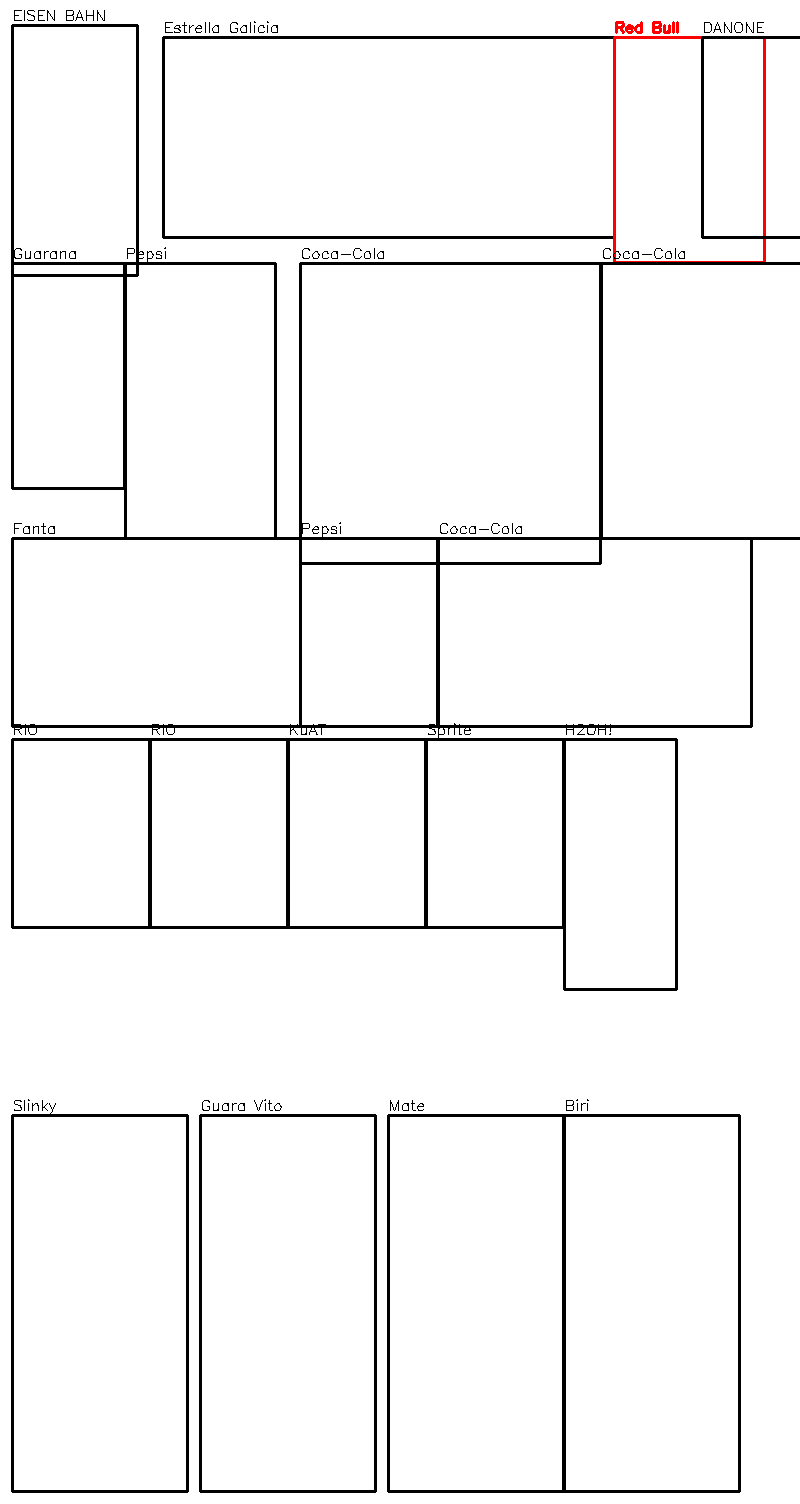

[INFO] 1 unique segments found


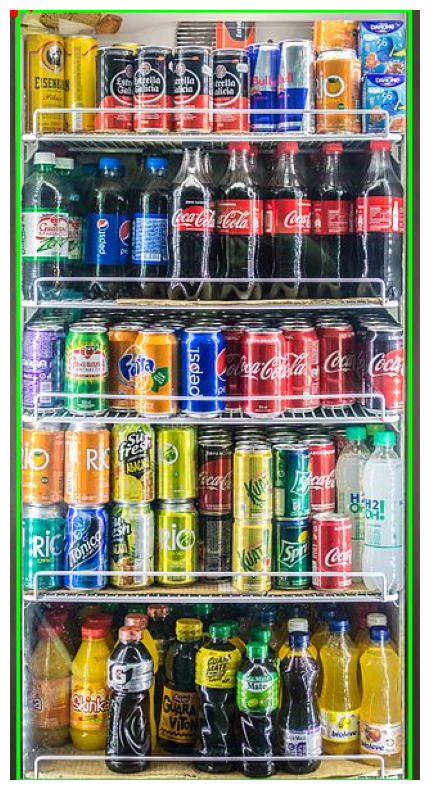

True

In [20]:
def visualize_planogram(planogram, target_width):
    width = int(planogram['planogram'].get('width'))
    height = int(planogram['planogram'].get('height'))
    aspect_ratio = width / height
    target_height = int(target_width / aspect_ratio)
    image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    image.fill(255)

    for product in planogram['planogram'].get('products', []):
        x = int(product['x'] * target_width / width)
        y = int(product['y'] * target_height / height)
        w = int(product['w'] * target_width / width)
        h = int(product['h'] * target_height / height)
        if product['name'] == 'Red Bull':
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(image, product['name'], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        else:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), 2)
            if 'name' in product:
                cv2.putText(image, product['name'], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for fixture in planogram['planogram'].get('fixtures', []):
        x = int(fixture['x'] * target_width / width)
        y = int(fixture['y'] * target_height / height)
        w = int(fixture['w'] * target_width / width)
        h = int(fixture['h'] * target_height / height)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for position in planogram['planogram'].get('positions', []):
        x = int(position['x'] * target_width / width)
        y = int(position['y'] * target_height / height)
        cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    return image

planogram = json.load(open('detected_planogram.json', 'r'))
viz_planogram = visualize_planogram(planogram, 800)
viz_planogram = cv2.cvtColor(viz_planogram, cv2.COLOR_BGR2RGB)
display(Image.fromarray(viz_planogram))
image_path = 'assets/test_beverage.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")
originalImage = image.copy()

shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, labels=thresh, min_distance=20)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
if markers.shape != thresh.shape:
    markers = cv2.resize(markers, (thresh.shape[1], thresh.shape[0]), interpolation=cv2.INTER_NEAREST)

labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

if not os.path.exists("croppedImages"):
    os.makedirs("croppedImages")

i = 0
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    roi = originalImage[y:y + h, x:x + w]
    cv2.imwrite('croppedImages/' + str(label) + '.jpg', roi)
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    i = i + 1

def show_image(image):
    plt.figure(figsize=(10, 10))
    plt.axis(False)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

show_image(image)
cv2.imwrite("segmented_image.jpg", image)

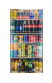

In [13]:
if not os.path.exists("croppedImages"):
    os.makedirs("croppedImages")
allTemplates = []
for template_name in os.listdir("croppedImages/"):
    template = cv2.imread("croppedImages/" + template_name)
    if template is not None:  # Check if image was loaded successfully
        allTemplates.append(template)

fig = plt.Figure(figsize=(1000,1000), dpi=300)

cols_count = 10
rows_count = 5

for id, template_image in enumerate(allTemplates):
    plt.subplot(rows_count, cols_count, id+1)
    plt.axis(False)
    plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))

In [14]:
THRESHOLD_MATCH = 0.8
def filtersubset(allTemplates):
    count = 0
    counts = [1]*len(allTemplates)
    for id1,temp1 in enumerate(allTemplates):
        for id2,temp2 in enumerate(allTemplates):
            w1,h1,c = temp1.shape
            w2,h2,c = temp2.shape
            if((w1>w2)and(h1>h2)):
                res = cv2.matchTemplate(temp1,temp2,cv2.TM_CCORR_NORMED)
                threshold = THRESHOLD_MATCH
                flag = False
                if np.amax(res)>threshold:
                    flag = True
                    if(counts[id1]==0):
                        continue
                        
                    counts[id1]+=counts[id2]
                    counts[id2] = 0
            
            if((w2>w1) and (h2>h1)):
                res = cv2.matchTemplate(temp2,temp1,cv2.TM_CCORR_NORMED)
                threshold = THRESHOLD_MATCH
                
                flag = False
                if np.amax(res)>threshold:
                    flag = True
                    if(counts[id2]==0):
                        continue
                        
                    counts[id2]+=counts[id1]
                    counts[id1] = 0
                    
    return counts

filter_templates_count = filtersubset(allTemplates)
filter_templates_count

[1]

In [15]:
num = 0
for val in filter_templates_count:
    if(val>0):
        num+=1
    
print(num)

1


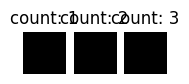

In [16]:
filter_templates_count = [1, 2, 0, 3]
allTemplates = [np.zeros((10, 10, 3), dtype=np.uint8) for _ in range(4)]

num = sum(1 for count in filter_templates_count if count > 0)
num_cols = 10
num_rows = math.ceil(num / num_cols)

fig = plt.Figure()

objects_with_count = []
current_count = 1
for index, count in enumerate(filter_templates_count):
    if count > 0:
        plt.subplot(num_rows, num_cols, current_count)
        template_image = allTemplates[index]
        plt.axis(False)
        plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
        plt.title("count: " + str(count))
        objects_with_count.append({"image": template_image, "count": count})
        current_count += 1

plt.show()

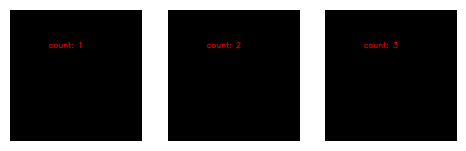

In [17]:
def write_on_image(objects_with_count):
    written_images = []
    for object_and_count in objects_with_count:
        image = object_and_count["image"]
        w, h, c = image.shape
        image = cv2.resize(image, (512, 512))
        count = object_and_count["count"]
        image = cv2.putText(image, "count: " + str(count), (150, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        image = cv2.resize(image, (512, int(h * 512 / w)))
        written_images.append(image)
    return written_images

def show_multiple_images(allimages):
    num_images = len(allimages)
    num_cols = 10
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

    for id, image in enumerate(allimages):
        cv2.imwrite("count_results/" + str(id) + ".jpg", image)
        plt.subplot(num_rows, num_cols, id + 1)
        plt.axis(False)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.show()

# Assuming objects_with_count is defined
objects_with_count = [
    {"image": np.zeros((100, 100, 3), dtype=np.uint8), "count": 1},
    {"image": np.zeros((100, 100, 3), dtype=np.uint8), "count": 2},
    {"image": np.zeros((100, 100, 3), dtype=np.uint8), "count": 3},
]

final_images = write_on_image(objects_with_count)
show_multiple_images(final_images)